In [128]:
import ProtobufTypes_pb2 
import pandas as pd
import sys
import collections
import numpy as np
import glob
import seaborn as sns
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pickle
import pprint
from IPython.display import display
from datetime import date
import datetime as dt
import matplotlib.patches as mpatches
# rcParams.keys()

In [54]:
PROCESSED_DATA_PATH = '../processed_data/EIH_1/'
META_DATA_PATH ='../experiment_meta'
# PLOT_PATH = f'./PLOTS-{date.today().strftime("%b-%d-%Y")}/fixations_grasps/'
PLOT_PATH = './plots_grasp_aligned_fixations_final/'

os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)

sns.set(context = "talk", style="white", palette="muted", font_scale=1,\
        rc={'figure.figsize':(11.7,8.27), 'font.size':15,
            'font.sans-serif':'DejaVu Sans'})

In [55]:
shelf_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/00_ET_shelfData_master.csv')
shelf_df.rename(
    columns={'trialNum':'trial_num', 'subjectID':'subject_id', 'trialID':'trial_id'}, inplace=True)

shelf_df['position_x'] = shelf_df['position_x'].astype(int) + 1
shelf_df['position_y'] = shelf_df['position_y'].astype(int) + 1
shelf_df['shelf_id'] = shelf_df['position_y'].astype(str) + '_' + shelf_df['position_x'].astype(str)
shelf_df['object'] = shelf_df['shape'] + '_' + shelf_df['color']
shelf_df.rename(columns={'position_x': 'pos_x', 'position_y':'pos_y'}, inplace=True)
shelf_df['trial_type'] = (
    shelf_df
    .trial_id
    .apply(lambda s: 'easy' if s in np.arange(0,8) else 'hard')
)
display(shelf_df.head())
display(shelf_df.subject_id.nunique())

,shape,pos_x,pos_y,color,trial_id,subject_id,subjectfileName,trial_num,shelf_id,object,trial_type
0,Cube,5,3,Red,0.0,2006,../experiment_et_data\subject2006.etd,0,3_5,Cube_Red,easy
1,Cylinder,1,5,Red,0.0,2006,../experiment_et_data\subject2006.etd,0,5_1,Cylinder_Red,easy
2,Sphere,3,3,Red,0.0,2006,../experiment_et_data\subject2006.etd,0,3_3,Sphere_Red,easy
3,Tetraeder,5,4,Red,0.0,2006,../experiment_et_data\subject2006.etd,0,4_5,Tetraeder_Red,easy
4,Cube,1,2,Blue,0.0,2006,../experiment_et_data\subject2006.etd,0,2_1,Cube_Blue,easy


59

22624

1.0

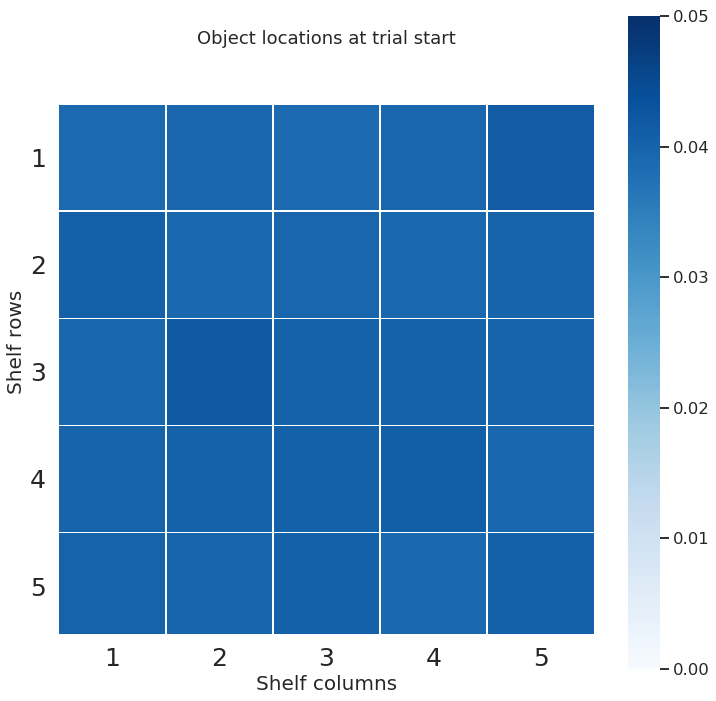

In [56]:
tmpdf = (
    shelf_df
    .groupby(['pos_x', 'pos_y'], as_index=False)
    .shelf_id
    .count()
)
# tmpdf.shelfID = tmpdf.shelfID/tmpdf.shelfID.sum()
tmpdf = tmpdf.pivot(index='pos_y', columns = 'pos_x', values='shelf_id')
# display(tmpdf)
display(tmpdf.sum(axis=1).sum())
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())

# display(tmpdf)
display(tmpdf.sum(axis=1).sum())
_, _ = plt.subplots(1,1,figsize=(12,12))
ax = sns.heatmap(tmpdf,vmin=0, vmax=0.05, linewidths=.5, cmap='Blues', square=True)
ax.set_ylim(len(tmpdf)-0.05, -0.5)
plt.yticks(rotation=0, fontsize=25) 
plt.xticks(rotation=0, fontsize=25)
plt.xlabel('Shelf columns', fontsize=20)
plt.ylabel('Shelf rows', fontsize=20)

plt.title('Object locations at trial start')
plt.savefig(PLOT_PATH+'/shelf_randomization.png', quality=90, transparent=True);

## Get shelf centers

In [57]:
files = glob.glob(f'{META_DATA_PATH}/*_pos.csv')
shelf_centers = pd.DataFrame()
for f in files:
    tmpdf = pd.read_csv(f, sep=';')
    tmpdf['object'] = f.split('\\')[1].split('_')[0]
    shelf_centers = pd.concat([shelf_centers, tmpdf], ignore_index=True)

shelf_centers.gridPosition = shelf_centers.gridPosition.str.strip('()')
shelf_centers[['pos_x', 'pos_y']] = shelf_centers.gridPosition.str.split(',', expand=True)
shelf_centers['world position'] = shelf_centers['world position'].str.strip('()')

display(shelf_centers)
shelf_centers[['center_x', 'center_y', 'center_z']] = shelf_centers['world position'].str.split(' ', expand=True)
shelf_centers.center_x = shelf_centers.center_x.str.replace(',', '.').str.strip('.')
shelf_centers.center_y = shelf_centers.center_y.str.replace(',', '.').str.strip('.')
shelf_centers.center_z = shelf_centers.center_z.str.replace(',', '.').str.strip('.')
shelf_centers.drop(columns=['gridPosition', 'world position'], inplace=True)
shelf_centers = shelf_centers.astype({'pos_x':'int32',
                                      'pos_y':'int32',
                                      'center_x':'float64',
                                      'center_y':'float64',
                                      'center_z':'float64'})
# shelf_centers = (shelf_centers
#                  .groupby(['pos_x', 'pos_y'], as_index=False)
#                  .agg({'center_x':'mean',
#                        'center_y':'mean',
#                        'center_z':'mean',
#                       })
#                 )
shelf_centers.pos_x = shelf_centers.pos_x + 1
shelf_centers.pos_y = shelf_centers.pos_y + 1
shelf_centers['shelfID'] = shelf_centers.pos_y.astype(str)+'_'+shelf_centers.pos_x.astype(str)
shelf_centers.object = shelf_centers.object.map({'cube':'Cube',
                                                 'sphere':'Sphere',
                                                 'cylinder':'Cylinder',
                                                 'pyramid':'Tetraeder'})
display(shelf_centers)

,gridPosition,world position,object,pos_x,pos_y
0,"0, 0","-0,882, 1,926, 0,211",cube,0,0
1,"1, 0","-0,436, 1,926, 0,211",cube,1,0
2,"2, 0","0,010, 1,926, 0,211",cube,2,0
3,"3, 0","0,456, 1,926, 0,211",cube,3,0
4,"4, 0","0,902, 1,926, 0,211",cube,4,0
...,...,...,...,...,...
95,"0, 4","-0,882, 0,161, 0,211",sphere,0,4
96,"1, 4","-0,436, 0,161, 0,211",sphere,1,4
97,"2, 4","0,010, 0,161, 0,211",sphere,2,4
98,"3, 4","0,456, 0,161, 0,211",sphere,3,4


,object,pos_x,pos_y,center_x,center_y,center_z,shelfID
0,Cube,1,1,-0.882,1.926,0.211,1_1
1,Cube,2,1,-0.436,1.926,0.211,1_2
2,Cube,3,1,0.010,1.926,0.211,1_3
3,Cube,4,1,0.456,1.926,0.211,1_4
4,Cube,5,1,0.902,1.926,0.211,1_5
...,...,...,...,...,...,...,...
95,Sphere,1,5,-0.882,0.161,0.211,5_1
96,Sphere,2,5,-0.436,0.161,0.211,5_2
97,Sphere,3,5,0.010,0.161,0.211,5_3
98,Sphere,4,5,0.456,0.161,0.211,5_4


## Get shelf location at grasp start and grasp end

In [58]:
samples_df = pd.read_csv(
    '../processed_data/EIH_1/05_ET_samples_graspInfo.csv',
    parse_dates = ['timestamp_dt'],
    sep=',',
    dtype = {
        'isFixV': np.bool, 'grasp_onset_bool': np.bool,'grasp_end_bool': np.bool,
#         'subjectID': np.int32, 'trial_num': np.int32, 'trialID': np.int32,
    },
    index_col=False,
)

samples_df = samples_df.rename(columns = {
    'subjectID': 'subject_id',
#     'trialNum' : 'trial_num',
    'combinedEye_raycastHitObject' : 'eye_hit',
    'eye_shelfHits' : 'eye_shelf_hit',
    'trialID' : 'trial_id',
    'isFixV' : 'is_fixation',
    'nosePointer_shelfHits' : 'head_hit',
    'isOutlierFix' : 'is_outlier_fixation',
    'handData_graspedObject' : 'grasp'
    
})
print(samples_df.shape)
print(samples_df.query('eye_shelf_hit == "ERROR"').shape)

samples_df = (
    samples_df
#     .query('subject_id not in [2011, 2039, 2034, 2042, 2046]')
    .query('eye_shelf_hit != "ERROR"')
    .query('subject_id != 2022 and trial_num != 0')
    .query('subject_id != 2044 and trial_num != 1')
)

samples_df.loc[
    (
        (samples_df.subject_id == 2040)
        & (samples_df.subjectfileName.str.endswith('_2.etd'))
    ), 'trial_num'
] += 3

samples_df['trial_type'] = (
    samples_df
    .trial_id
    .apply(lambda s: 'easy' if s in np.arange(0,8) else 'hard')
)

samples_df = samples_df[[
    'subject_id', 'trial_num', 'trial_type', 'timestamp_dt', 'is_fixation', 'eye_hit', 'grasp',
    'grasp_onset_bool', 'eye_shelf_hit', 'fix_duration', 'grasp_end_bool', 'grasp_duration', 
    'is_outlier_fixation', 'pickup_location', 'drop_location'
]]

valid_objs = ['Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow',
    'Cylinder_Blue', 'Cylinder_Green', 'Cylinder_Red','Cylinder_Yellow',
    'Sphere_Blue', 'Sphere_Green', 'Sphere_Red', 'Sphere_Yellow', 
    'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow']

samples_df.loc[~(samples_df.eye_hit.isin(valid_objs)) & 
           ~(pd.isnull(samples_df.eye_hit)),
               'eye_hit'] ='Other'

samples_df.head()

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (31,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(10153442, 71)
(0, 71)


,subject_id,trial_num,trial_type,timestamp_dt,is_fixation,eye_hit,grasp,grasp_onset_bool,eye_shelf_hit,fix_duration,grasp_end_bool,grasp_duration,is_outlier_fixation,pickup_location,drop_location
8905,2006.0,2.0,hard,1970-01-01 00:00:00.351460844,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN
8906,2006.0,2.0,hard,1970-01-01 00:00:00.360775739,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN
8907,2006.0,2.0,hard,1970-01-01 00:00:00.371934354,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN
8908,2006.0,2.0,hard,1970-01-01 00:00:00.383572042,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN
8909,2006.0,2.0,hard,1970-01-01 00:00:00.394215554,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN


In [59]:
samples_df.set_index('timestamp_dt', inplace=True)

In [60]:
display(samples_df.pickup_location.isna().mean())
display(samples_df.drop_location.isna().mean())

0.9980695404310922

0.9980695404310922

In [61]:
samples_df.head()

,subject_id,trial_num,trial_type,is_fixation,eye_hit,grasp,grasp_onset_bool,eye_shelf_hit,fix_duration,grasp_end_bool,grasp_duration,is_outlier_fixation,pickup_location,drop_location
timestamp_dt,,,,,,,,,,,,,,
1970-01-01 00:00:00.351460844,2006.0,2.0,hard,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN
1970-01-01 00:00:00.360775739,2006.0,2.0,hard,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN
1970-01-01 00:00:00.371934354,2006.0,2.0,hard,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN
1970-01-01 00:00:00.383572042,2006.0,2.0,hard,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN
1970-01-01 00:00:00.394215554,2006.0,2.0,hard,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN


In [62]:
def get_grasps(sample_df): 
    sample_df = sample_df.sort_values(by='timestamp_dt')
    grasp_times = (
        sample_df.query('grasp_onset_bool == 1')
        [['pickup_location', 'grasp', 'timestamp_dt']]
        .rename(columns=dict(
            timestamp_dt='on_time',
            grasp='current_TO',
        ))
    )
    grasp_times['off_time'] = sample_df.query('grasp_end_bool == 1').timestamp_dt.values
    grasp_times['drop_location'] = sample_df.query('grasp_end_bool == 1').drop_location.values
    grasp_times = grasp_times.sort_values(by='on_time').reset_index(drop=True)

    grasp_times = grasp_times.drop_duplicates(subset = ['pickup_location', 'drop_location', 'current_TO'], keep='first')

    grasp_times = grasp_times.query('pickup_location != drop_location')
    grasp_times['between_grasp_duration'] = (grasp_times['on_time'].shift(-1) - grasp_times['on_time'])/np.timedelta64(1, 's')
    grasp_times['in_grasp_duration'] = (grasp_times['off_time'] - grasp_times['on_time'])/np.timedelta64(1, 's')
    
    grasp_times[['pickup_x','pickup_y']] = grasp_times.pickup_location.str.split('_', expand=True)
    grasp_times[['drop_x','drop_y']] = grasp_times.drop_location.str.split('_', expand=True)
    grasp_times['offset_x'] = grasp_times.drop_x.astype(int) - grasp_times.pickup_x.astype(int)
    grasp_times['offset_y'] = grasp_times.drop_y.astype(int) - grasp_times.pickup_y.astype(int)
    grasp_times['grasp_num'] = grasp_times.index
    
    return grasp_times.set_index('grasp_num')

grp_cols = ['subject_id', 'trial_type', 'trial_num']
grasp_df = (
    samples_df
    .reset_index()
#         .query('subject_id == @subjects')
    .groupby(grp_cols)
    .apply(get_grasps)        
)
# df.reset_index(level=2, drop=True)

display(grasp_df.head())

pickup_location       current_TO  \
subject_id trial_type trial_num grasp_num                                    
2006.0     easy       5.0       0                     2_1  Tetraeder_Green   
                                1                     2_2      Cube_Yellow   
                                2                     1_4     Sphere_Green   
                                3                     2_4  Cylinder_Yellow   
                                4                     2_5         Cube_Red   

                                                                on_time  \
subject_id trial_type trial_num grasp_num                                 
2006.0     easy       5.0       0         1970-01-01 00:00:05.835639477   
                                1         1970-01-01 00:00:07.633999825   
                                2         1970-01-01 00:00:12.176501274   
                                3         1970-01-01 00:00:15.264882088   
                                4         1970-01-01 00:00:17.475528717   

                                                               off_time  \
subject_id trial_type trial_num grasp_num                                 
2006.0     easy       5.0       0         1970-01-01 00:00:06.802226543   
                                1         1970-01-01 00:00:10.744694710   
                                2         1970-01-01 00:00:13.243731499   
                                3         1970-01-01 00:00:16.397928238   
                                4         1970-01-01 00:00:19.519012451   

                                          drop_location  \
subject_id trial_type trial_num grasp_num                 
2006.0     easy       5.0       0                   1_1   
                                1                   1_3   
                                2                   2_2   
                                3                   1_4   
                                4                   2_3   

                                           between_grasp_duration  \
subject_id trial_type trial_num grasp_num                           
2006.0     easy       5.0       0                        1.798360   
                                1                        4.542501   
                                2                        3.088381   
                                3                        2.210647   
                                4                        3.331923   

                                           in_grasp_duration pickup_x  \
subject_id trial_type trial_num grasp_num                               
2006.0     easy       5.0       0                   0.966587        2   
                                1                   3.110695        2   
                                2                   1.067230        1   
                                3                   1.133046        2   
                                4                   2.043484        2   

                                          pickup_y drop_x drop_y  offset_x  \
subject_id trial_type trial_num grasp_num                                    
2006.0     easy       5.0       0                1      1      1        -1   
                                1                2      1      3        -1   
                                2                4      2      2         1   
                                3                4      1      4        -1   
                                4                5      2      3         0   

                                           offset_y  
subject_id trial_type trial_num grasp_num            
2006.0     easy       5.0       0                 0  
                                1                 1  
                                2                -2  
                                3                 0  
                                4                -2

In [63]:
display(grasp_df.shape)

(16293, 13)

In [97]:
model_df = pd.DataFrame()
files = glob.glob('shelf_model/collected_depths/task*.pickle')
print(files)
for idx, f in enumerate(files):
    tmpdf = pd.DataFrame()
    with open(f, 'rb') as handle:
        tmp = pickle.load(handle)
    
    if idx == 0:
        tmpdf['num_grasp'] = pd.Series([t[1] for t in tmp])
    else:
        tmpdf['num_grasp'] = pd.Series([t for t in tmp])
        
    
    tmpdf['trial_type'] = f
    print(tmpdf.shape[0])
    model_df = pd.concat([model_df, tmpdf], ignore_index=True)

model_df.trial_type = model_df.trial_type.str.split('\\', expand=True)[1].str.split('.', expand=True)[0]
model_df.trial_type = model_df.trial_type.map({'task1':'easy', 'task2':'hard', 'task3':'hard'})
model_df['subject_id'] = 'model_sub'
model_df['trial_num'] = 'model_trial'
model_df['type'] = 'optimal'
display(model_df)

['shelf_model/collected_depths\\task1.pickle', 'shelf_model/collected_depths\\task2.pickle', 'shelf_model/collected_depths\\task3.pickle']
4008
3608
2937


,num_grasp,trial_type,subject_id,trial_num,type
0,9,easy,model_sub,model_trial,optimal
1,8,easy,model_sub,model_trial,optimal
2,10,easy,model_sub,model_trial,optimal
3,13,easy,model_sub,model_trial,optimal
4,8,easy,model_sub,model_trial,optimal
...,...,...,...,...,...
10548,9,hard,model_sub,model_trial,optimal
10549,9,hard,model_sub,model_trial,optimal
10550,11,hard,model_sub,model_trial,optimal
10551,13,hard,model_sub,model_trial,optimal


In [144]:
model_df.groupby('trial_type').num_grasp.describe()

,count,mean,std,min,25%,50%,75%,max
trial_type,,,,,,,,
easy,4008.0,9.423403,1.488202,4.0,8.0,9.0,10.0,16.0
hard,6545.0,11.242934,2.786015,3.0,9.0,11.0,13.0,23.0


In [91]:
sns.color_palette('muted', 10)

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

,count,mean,std,min,25%,50%,75%,max
trial_type,,,,,,,,
easy,4696.0,9.611797,2.073275,2.0,8.0,9.0,10.0,33.0
hard,7037.0,11.725167,4.519877,3.0,9.0,11.0,13.0,109.0


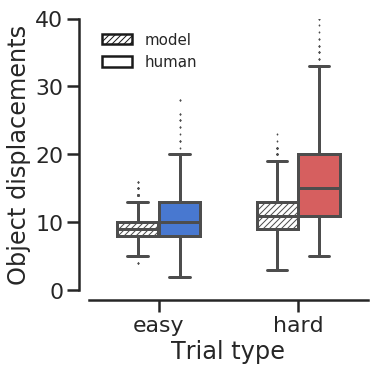

In [143]:
sns.set(context = "poster", style="ticks", palette="muted", font_scale=1,\
        rc={'font.size':30, 'font.sans-serif':'DejaVu Sans'})

scpt = sns.color_palette('muted', 10)
tmpdf = (
    grasp_df
    .reset_index()
    .groupby(['subject_id', 'trial_num','trial_type',], as_index=False)
    .grasp_num
    .count()
    .rename(columns = {'grasp_num':'num_grasp'})
)
tmpdf['type'] = 'human'
tmpdf = pd.concat([model_df,tmpdf])

display(tmpdf.groupby('trial_type').num_grasp.describe())
_, ax = plt.subplots(1,1, figsize=(5,5))

ax = sns.boxplot(
    data=tmpdf,
    x='trial_type',
    y='num_grasp',
    hue='type',
    palette=['white', 'grey'],
    order=['easy', 'hard'],
    linewidth=3,
    fliersize=1,
    dodge=0.4,
    width=0.6
)
mybox = ax.artists[0]
mybox.set_facecolor('white')
mybox.set_hatch('////')

mybox = ax.artists[1]
mybox.set_facecolor(scpt[0])

mybox = ax.artists[2]
mybox.set_facecolor('white')
mybox.set_hatch('////')

mybox = ax.artists[3]
mybox.set_facecolor(scpt[3])
ax.set_ylim(0,40)
# plt.xticks(rotation=90, fontsize=15)
ax.set_ylabel('Object displacements')
ax.set_xlabel('Trial type')
l1 = mpatches.Patch(edgecolor='k',lw=2.5, facecolor='white', hatch='////', label='model')
l2= mpatches.Patch(edgecolor='k', lw=2.5, facecolor='white', hatch='', label='human')

ax.legend(handles=[l1,l2], loc='upper left', frameon=False, fontsize=15, ncol=1)
sns.despine(offset=10)
plt.savefig(PLOT_PATH+'/grasps.png', quality=90, bbox_inches='tight')

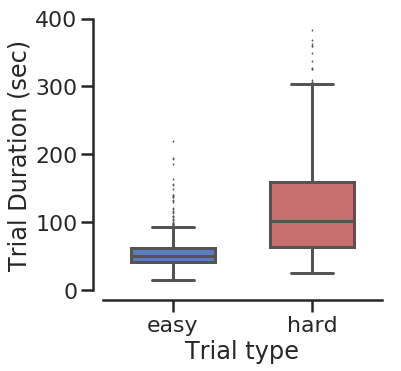

In [44]:
sns.set(context = "poster", style="ticks", palette="muted", font_scale=1,\
        rc={'font.size':30, 'font.sans-serif':'DejaVu Sans'})
tmpdf = (
    samples_df
#     .set_index('timestamp_dt')
    .groupby(['subject_id','trial_type', 'trial_num'])
    .apply(lambda x: (x.index[-1] - x.index[0])/np.timedelta64(1, 's'))
    .rename('trial_duration')
    .reset_index()
)
# display(tmpdf)


_, ax = plt.subplots(1,1,figsize=(5,5))
sns.boxplot(
    data=tmpdf, 
    x='trial_type', 
    y='trial_duration', 
    palette = ['b', 'r'],
    linewidth=3,
    fliersize=1,
    width=0.6
)


ax.set_ylim(0, 400)
# plt.xticks(rotation=90, fontsize=15)
plt.ylabel('Trial Duration (sec)')
plt.xlabel('Trial type')
sns.despine(offset=10)
plt.savefig(PLOT_PATH+'/TrialDuration.png', quality=90, bbox_inches='tight')

pickup_x,1,2,3,4,5
pickup_y,,,,,
1,0.019680,0.026194,0.033116,0.040852,0.048860
2,0.029587,0.029723,0.034609,0.037866,0.046960
3,0.033795,0.037052,0.043838,0.040309,0.047231
4,0.036374,0.042481,0.041395,0.038409,0.048046
5,0.049131,0.048588,0.048860,0.048317,0.048724


pickup_x,1,2,3,4,5
pickup_y,,,,,
1,0.014118,0.033053,0.040896,0.039776,0.036527
2,0.027115,0.036863,0.049076,0.044370,0.039552
3,0.035294,0.043585,0.048627,0.045938,0.040560
4,0.036751,0.049860,0.051092,0.043361,0.035742
5,0.033613,0.047619,0.051204,0.037759,0.037647


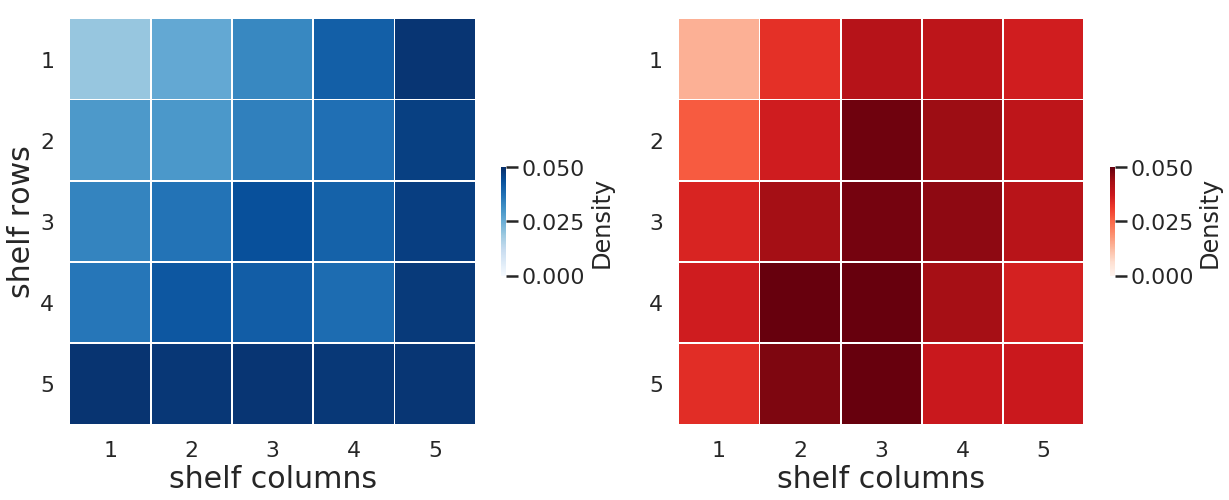

In [50]:
sns.set(context = "poster", style="white", palette="muted", font_scale=1,\
        rc={'font.size':30, 'font.sans-serif':'DejaVu Sans'})

_, ax = plt.subplots(1,2,figsize=(20,10))
tmpdf = (
    grasp_df
    .reset_index()
    .query('trial_type == "easy"')
    .groupby(['pickup_x','pickup_y'], as_index=False)
    .pickup_location
    .count()
)
# display(tmpdf)
tmpdf = tmpdf.pivot(index='pickup_y', columns = 'pickup_x', values='pickup_location')
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())
display(tmpdf)
sns.heatmap(tmpdf,vmin=0, vmax=0.05, linewidths=.6, cmap='Blues', square=True, ax=ax[0], cbar_kws={"shrink": 0.2,  'label': 'Density'},)
# ax[0].set_ylim(len(tmpdf)-0.05, -0.5)
ax[0].tick_params('y', labelrotation=0)
ax[0].set_xlabel('shelf columns', fontsize=30)
ax[0].set_ylabel('shelf rows', fontsize=30)

tmpdf = (
    grasp_df
    .reset_index()
    .query('trial_type == "hard"')
    .groupby(['pickup_x','pickup_y'], as_index=False)
    .pickup_location
    .count()
)
# display(tmpdf)
tmpdf = tmpdf.pivot(index='pickup_y', columns = 'pickup_x', values='pickup_location')
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())
display(tmpdf)
sns.heatmap(tmpdf,vmin=0, vmax=0.05, linewidths=.6, cmap='Reds', square=True, ax=ax[1], cbar_kws={"shrink": 0.2,  'label': 'Density'},)
# ax[1].set_ylim(len(tmpdf)-0.05, -0.5)
ax[1].tick_params('y', labelrotation=0)
ax[1].set_xlabel('shelf columns', fontsize=30)
ax[1].set_ylabel('', fontsize=30)


plt.savefig(PLOT_PATH+'/shelf_grasp_pickup_locations.png', quality=90, transparent=True)

drop_x,1,2,3,4,5
drop_y,,,,,
1,0.030673,0.045331,0.053882,0.047367,0.005293
2,0.048860,0.059853,0.067318,0.056596,0.008279
3,0.054832,0.069083,0.075461,0.057275,0.008822
4,0.051846,0.068811,0.072340,0.054289,0.006243
5,0.008279,0.014929,0.018458,0.013029,0.002850


drop_x,1,2,3,4,5
drop_y,,,,,
1,0.024538,0.042801,0.051877,0.048179,0.006387
2,0.042353,0.055574,0.066667,0.060616,0.009636
3,0.050644,0.061625,0.072605,0.060840,0.009636
4,0.051092,0.067227,0.073838,0.056022,0.008852
5,0.009748,0.022969,0.027899,0.015350,0.003025


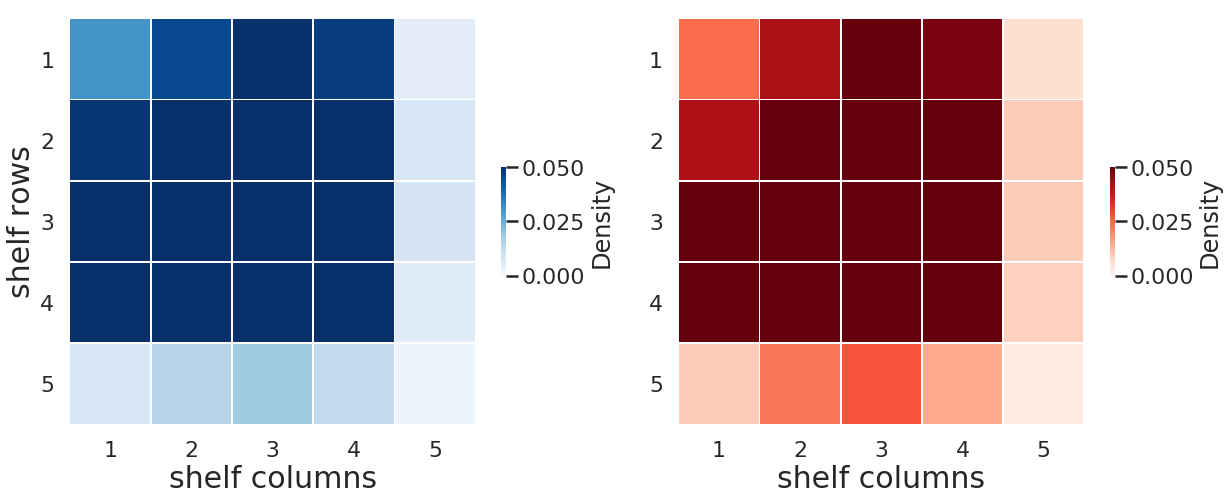

In [51]:
sns.set(context = "poster", style="white", palette="muted", font_scale=1,\
        rc={'font.size':30, 'font.sans-serif':'DejaVu Sans'})

_, ax = plt.subplots(1,2,figsize=(20,10))
tmpdf = (
    grasp_df
    .reset_index()
    .query('trial_type == "easy"')
    .groupby(['drop_x','drop_y'], as_index=False)
    .drop_location
    .count()
)
# display(tmpdf)
tmpdf = tmpdf.pivot(index='drop_y', columns = 'drop_x', values='drop_location')
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())
display(tmpdf)
sns.heatmap(tmpdf,vmin=0, vmax=0.05, linewidths=.6, cmap='Blues', square=True, ax=ax[0], cbar_kws={"shrink": 0.2,  'label': 'Density'},)
# ax[0].set_ylim(len(tmpdf)-0.05, -0.5)
ax[0].tick_params('y', labelrotation=0)

ax[0].set_xlabel('shelf columns', fontsize=30)
ax[0].set_ylabel('shelf rows', fontsize=30)

tmpdf = (
    grasp_df
    .reset_index()
    .query('trial_type == "hard"')
    .groupby(['drop_x','drop_y'], as_index=False)
    .drop_location
    .count()
)
# display(tmpdf)
tmpdf = tmpdf.pivot(index='drop_y', columns = 'drop_x', values='drop_location')
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())
display(tmpdf)
sns.heatmap(tmpdf,vmin=0, vmax=0.05, linewidths=.6, cmap='Reds', square=True, ax=ax[1], cbar_kws={"shrink": 0.2,  'label': 'Density'})
# ax[1].set_ylim(len(tmpdf)-0.05, -0.5)
ax[1].tick_params('y', labelrotation=0)
ax[1].set_xlabel('shelf columns', fontsize=30)
ax[1].set_ylabel('', fontsize=30)


plt.savefig(PLOT_PATH+'/shelf_grasp_drop_locations.png', quality=90, transparent=True)

offset_x,-4,-3,-2,-1,0,1,2,3,4
offset_y,,,,,,,,,
-4,0.000950,0.001900,0.004072,0.009636,0.007329,0.005565,0.003936,0.002714,0.000271
-3,0.002986,0.005700,0.008822,0.014658,0.014929,0.011944,0.007193,0.003257,0.000407
-2,0.004479,0.008958,0.019951,0.031623,0.031352,0.026330,0.014251,0.006379,0.001086
-1,0.006243,0.016558,0.037188,0.070440,0.069490,0.048588,0.024973,0.007736,0.001086
0,0.007193,0.013844,0.032980,0.056325,0.000000,0.023887,0.013301,0.003529,0.001221
1,0.004207,0.014658,0.030809,0.050217,0.036509,0.023344,0.012486,0.003529,0.000814
2,0.004886,0.009501,0.017237,0.020901,0.018594,0.011401,0.004750,0.001764,0.000407
3,0.004207,0.005700,0.007193,0.008550,0.006650,0.002850,0.002443,0.001357,0.000271
4,0.000136,0.000950,0.001493,0.001764,0.002307,0.001629,0.000543,0.000679,0.000000


offset_x,-4,-3,-2,-1,0,1,2,3,4
offset_y,,,,,,,,,
-4,0.000560,0.002017,0.002465,0.005602,0.006611,0.005154,0.003361,0.002129,0.000112
-3,0.001569,0.003922,0.007843,0.011653,0.014902,0.012437,0.006835,0.003361,0.000336
-2,0.003137,0.006499,0.013669,0.028123,0.033277,0.019720,0.011204,0.004930,0.000784
-1,0.004706,0.012773,0.030028,0.054454,0.071261,0.043361,0.018711,0.006499,0.000896
0,0.009300,0.014678,0.036078,0.079328,0.000000,0.056134,0.019944,0.009300,0.002465
1,0.003922,0.010980,0.023529,0.044706,0.053894,0.029804,0.010420,0.003810,0.000672
2,0.004258,0.007843,0.015126,0.021849,0.021176,0.011204,0.004482,0.001569,0.000336
3,0.002129,0.003922,0.005938,0.010084,0.008515,0.004258,0.002465,0.001345,0.000112
4,0.000112,0.000336,0.001681,0.001905,0.003810,0.001232,0.000448,0.000000,0.000000


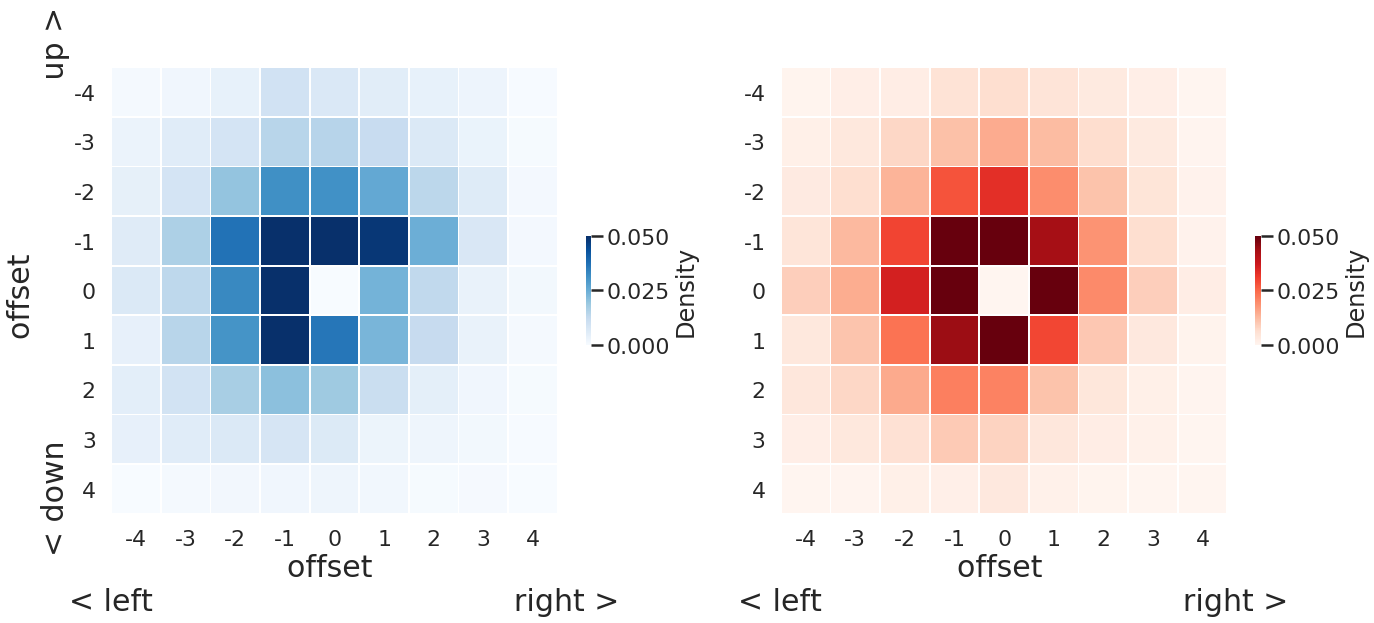

In [52]:
_, ax = plt.subplots(1,2,figsize=(22,10))
tmpdf = (
    grasp_df
    .reset_index()
    .query('trial_type == "easy"')
    .groupby(['offset_x','offset_y'], as_index=False)
    .drop_location
    .count()
)
# display(tmpdf)
tmpdf = tmpdf.pivot(index='offset_y', columns = 'offset_x', values='drop_location')
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())
tmpdf.fillna(0, inplace=True)
display(tmpdf)
sns.heatmap(
    tmpdf,vmin=0, vmax=0.05, 
    linewidths=.8, cmap='Blues', square=True, cbar_kws={"shrink": 0.2,  'label': 'Density'},
    ax=ax[0],
)
# ax[0].set_ylim(len(tmpdf)-0.05, -0.5)
# ax[0].set_yticks(rotation=0, fontsize=25) 
ax[0].tick_params('y', labelrotation=0)
ax[0].set_xlabel('offset \n  < left                                      right >', fontsize=30)
ax[0].set_ylabel('offset \n  < down                                      up >', fontsize=30)

tmpdf = (
    grasp_df
    .reset_index()
    .query('trial_type == "hard"')
    .groupby(['offset_x','offset_y'], as_index=False)
    .drop_location
    .count()
)
# display(tmpdf)
tmpdf = tmpdf.pivot(index='offset_y', columns = 'offset_x', values='drop_location')
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())
tmpdf.fillna(0, inplace=True)

display(tmpdf)
sns.heatmap(
    tmpdf,vmin=0, vmax=0.05, 
    linewidths=.8, cmap='Reds', square=True, cbar_kws={"shrink": 0.2,  'label': 'Density'},
    ax=ax[1],
)
# ax[1].set_ylim(len(tmpdf)-0.05, -0.5)
ax[1].tick_params('y', labelrotation=0)
ax[1].set_xlabel('offset \n  < left                                      right >', fontsize=30)
ax[1].set_ylabel('', fontsize=30)


plt.savefig(PLOT_PATH+'/shelf_grasp_offsets.png', quality=90, transparent=True)

In [ ]:
tmpdf =  (
    grasp_connections
    .groupby(['subjectID','drop_x','drop_y'], as_index=False)
    .drop_locations
    .count()
    .groupby(['drop_x','drop_y'], as_index=False)
    .drop_locations
    .mean()
)
# tmpdf.shelfID = tmpdf.shelfID/tmpdf.shelfID.sum()
tmpdf = tmpdf.pivot(index='drop_y', columns = 'drop_x', values='drop_locations')
# display(tmpdf)

_, ax = plt.subplots(1,1,figsize=(12,12))
ax = sns.heatmap(tmpdf,vmin=0, vmax=20, linewidths=.5, cmap='viridis_r', square=True)
ax.set_ylim(len(tmpdf)-0.05, -0.5)
plt.yticks(rotation=0, fontsize=25) 
plt.xticks(rotation=0, fontsize=25)
plt.xlabel('shelf columns', fontsize=20)
plt.ylabel('shelf rows', fontsize=20)
plt.title('Object drop locations at grasp end')
# plt.savefig(PLOT_PATH+'/shelf_graspDropLocations.png', quality=90, transparent=True)

In [ ]:
tmpdf = (
    grasp_connections
    .groupby(['pickup_locations', 'drop_locations'], as_index=False)
    .drop_x
    .count()
#     .groupby(['pickup_locations','drop_locations'], as_index=False)
#     .drop_x
#     .mean()
)
# tmpdf.shelfID = tmpdf.shelfID/tmpdf.shelfID.sum()
tmpdf = tmpdf.pivot(index='drop_locations', columns = 'pickup_locations', values='drop_x')
display(tmpdf)

_, ax = plt.subplots(1,1,figsize=(12,12))
ax = sns.heatmap(tmpdf,vmin=0, vmax=1000, linewidths=.5, cmap='Blues', square=True)
ax.set_ylim(len(tmpdf)-0.05, -0.5)
plt.yticks(rotation=0, fontsize=15) 
plt.xticks(rotation=90, fontsize=15)
plt.xlabel('shelf pick locations at grasp start', fontsize=15)
plt.ylabel('shelf drop locations at grasp end', fontsize=15)
plt.title('Object pickup & drop')
plt.savefig(PLOT_PATH+'/shelf_graspPicknDropLocations.png', quality=90, transparent=True)

In [ ]:
tmpdf = (
    grasp_connections
#     .groupby(['subjectID','trialNum', 'pickup_y', 'drop_y'], as_index=False)
    .groupby(['pickup_y', 'drop_y'], as_index=False)
    .pickup_locations
    .count()
#     .groupby(['pickup_y','drop_y'], as_index=False)
#     .pickup_locations
#     .mean()
)
# tmpdf.shelfID = tmpdf.shelfID/tmpdf.shelfID.sum()
tmpdf = tmpdf.pivot(index='drop_y', columns = 'pickup_y', values='pickup_locations')
display(tmpdf)

_, ax = plt.subplots(1,1,figsize=(12,12))
ax = sns.heatmap(tmpdf,vmin=0, vmax=1000, linewidths=.5, cmap='viridis_r', square=True)
ax.set_ylim(len(tmpdf)-0.05, -0.5)
plt.yticks(rotation=0, fontsize=15) 
plt.xticks(rotation=0, fontsize=15)
plt.xlabel('shelf pickup row locations at grasp start', fontsize=15)
plt.ylabel('shelf drop row locations at grasp end', fontsize=15)
plt.title('Object pickup & drop based on rows')
plt.savefig(PLOT_PATH+'/shelf_graspRowPicknDropLocations.png', quality=90, transparent=True)

In [ ]:
tmpdf = (
    grasp_connections
#     .groupby(['subjectID','trialNum', 'pickup_x', 'drop_x'], as_index=False)
    .groupby(['pickup_x', 'drop_x'], as_index=False)
    .pickup_locations
    .count()
#     .groupby(['pickup_x','drop_x'], as_index=False)
#     .pickup_locations
#     .mean()
)
# tmpdf.pickup_locations = tmpdf.pickup_locations/tmpdf.pickup_locations.sum()
tmpdf = tmpdf.pivot(index='drop_x', columns = 'pickup_x', values='pickup_locations')
display(tmpdf)

_, ax = plt.subplots(1,1,figsize=(12,12))
ax = sns.heatmap(tmpdf,vmin=0, vmax=1000, linewidths=.5, cmap='viridis_r', square=True)
ax.set_ylim(len(tmpdf)-0.05, -0.5)
plt.yticks(rotation=0, fontsize=15) 
plt.xticks(rotation=0, fontsize=15)
plt.xlabel('shelf pickup column locations at grasp start', fontsize=15)
plt.ylabel('shelf drop column locations at grasp end', fontsize=15)
plt.title('Object pickup & drop based on columns')
plt.savefig(PLOT_PATH+'/shelf_graspColPicknDropLocations.png', quality=90, transparent=True)

In [ ]:
tmpdf =  (
    grasp_connections
    .groupby(['offset_x','offset_y'], as_index=False)
    .drop_locations
    .count()
)
# tmpdf.shelfID = tmpdf.shelfID/tmpdf.shelfID.sum()
tmpdf = tmpdf.pivot(index='offset_y', columns = 'offset_x', values='drop_locations')
tmpdf.fillna(0, inplace=True)
tmpdf = tmpdf.astype(int)
display(tmpdf)


_, ax = plt.subplots(1,1,figsize=(15,15))
ax = sns.heatmap(tmpdf,vmin=0, vmax=1200, linewidths=.5, cmap='Blues', square=True, annot=True, fmt="d")
ax.set_ylim(len(tmpdf)-0.05, -0.5)
plt.yticks(rotation=0, fontsize=25) 
plt.xticks(rotation=0, fontsize=25)
plt.xlabel('placement offset (drop - pickup) columns ', fontsize=20)
plt.ylabel('placement offset (drop - pickup) rows', fontsize=20)
plt.title('Object drop offset between grast start and grasp end')
plt.savefig(PLOT_PATH+'/movement_offset.png', quality=90, transparent=True)